# ЗАДАНИЕ

Выберите ряд из первого задания и постройте его модель ARIMA/GARCH. Отчет нужно будет оформить в jupyter-ноутбук.
Дополнительное задание: попробуйте спрогнозировать график классическим ML.

In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline

from arch import arch_model

In [21]:
dowjones_closing = pd.read_csv("weekly-closings-of-the-dowjones-.csv")['Close']

In [4]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [5]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

Results of Dickey-Fuller Test:
Test Statistic                  -1.314625
p-value                          0.622455
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


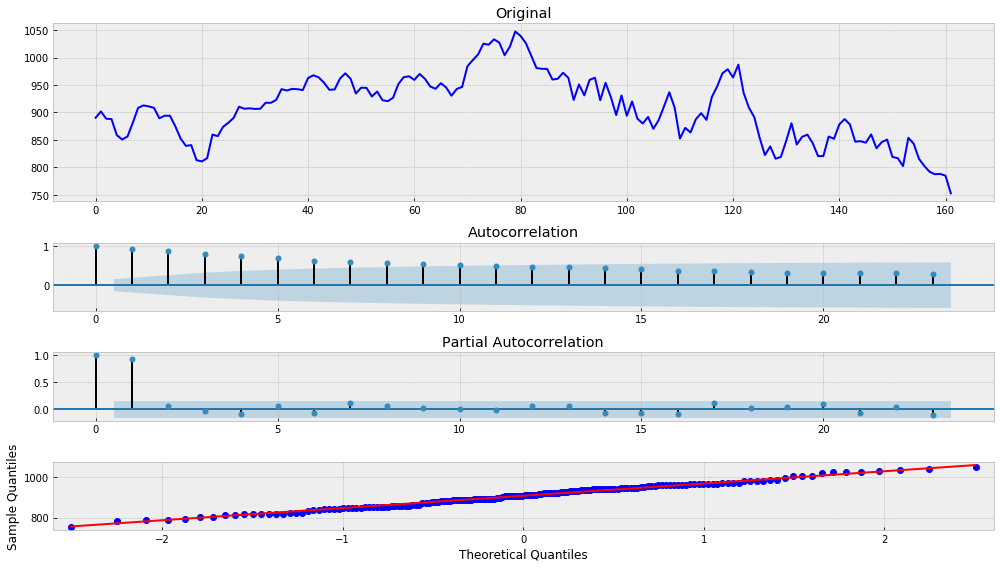

In [6]:
tsplot(dowjones_closing)

In [22]:
series = dowjones_closing
series = boxcox(series, 0)
series = series[12:] - series[:-12]
series = series[1:] - series[:-1]

# ARIMA

In [23]:
k = 0.1
split_day = round((1-k)*len(series))

In [24]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    for i in range(5):
        for d in range(5):
            for j in range(5):
                try:
                    tmp_mdl = smt.ARIMA(series, order=(i,d,j)).fit(method='mle', trend='nc')
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue

    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
    return best_aic, best_order, best_mdl

aic, order, mdl = _get_best_model(series[:split_day])

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInver

aic: -620.78849 | order: (3, 0, 3)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Results of Dickey-Fuller Test:
Test Statistic                -1.130163e+01
p-value                        1.303186e-20
#Lags Used                     0.000000e+00
Number of Observations Used    1.390000e+02
Critical Value (1%)           -3.478294e+00
Critical Value (5%)           -2.882568e+00
Critical Value (10%)          -2.577983e+00
dtype: float64


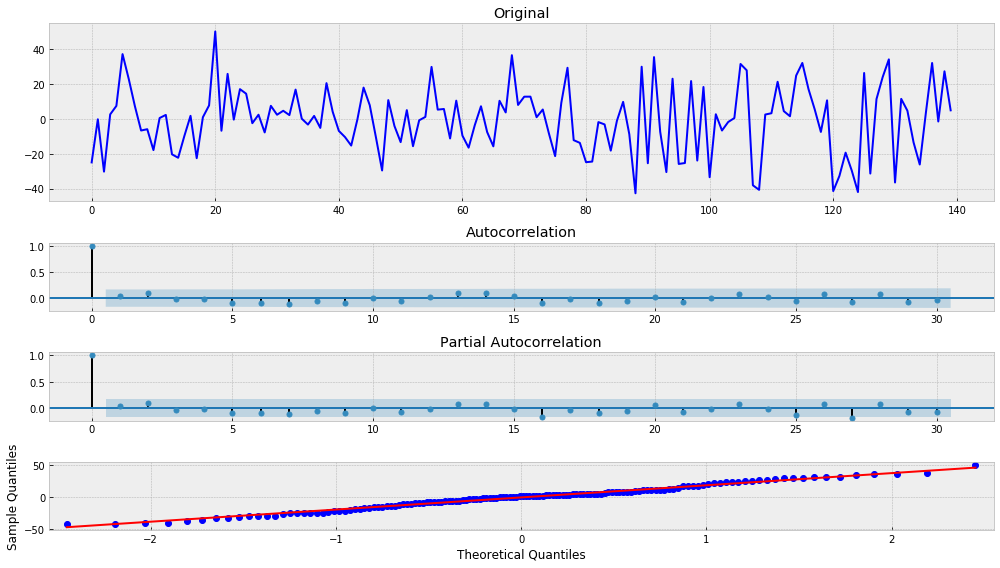

In [25]:
tsplot(best_mdl.resid, lags=30)

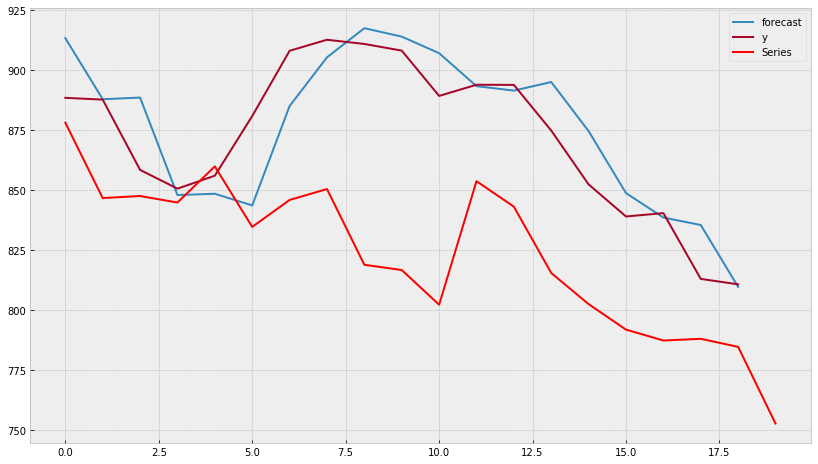

In [32]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    best_mdl.plot_predict(2, len(series_tst), ax=ax)
    plt.plot(series_tst, color='red', label='Series')
    plt.legend()
    plt.show()

In [33]:
print (f"ARIMA MSE ={np.sum(np.square(series_tst[1:] - best_mdl.predict(2,len(series_tst),typ='levels')))/(len(series_tst)-1):.2f}")

ARIMA MSE =4135.15


# GARCH

In [28]:
aic1, order1, mdl1 = _get_best_model(series[:split_day])

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:220: RuntimeWarning: divide by zero encountered in true_divide
  Z_mat, R_mat, T_mat)
/opt/anaconda3

aic: -620.78849 | order: (3, 0, 3)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [29]:
am = arch_model(series[:split_day], p=3, o=0, q=3, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                      -0.001
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                            GARCH   Log-Likelihood:                286.205
Distribution:      Standardized Student's t   AIC:                          -554.410
Method:                  Maximum Likelihood   BIC:                          -528.329
                                              No. Observations:                  134
Date:                      Sun, May 17 2020   Df Residuals:                      125
Time:                              15:25:26   Df Model:                            9
                                 Mean Model                                
                  coef    std err          t      P>|t|    95.0% Conf. Int.
---------------------------------------------------------------------------
mu     

/opt/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009183. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


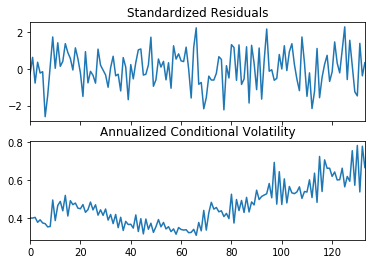

In [30]:
fig = res.plot(annualize='D')

# Прогнозирование графика классическим ML

In [10]:
ml_dj = pd.DataFrame(dowjones_closing.copy())
ml_dj.columns = ['Count']
lags = 5
for i in range(1,lags+1):
    ml_dj[f'lag_{i}'] = ml_dj.Count.shift(i)
ml_dj.dropna(inplace=True)

X_trn,y_trn = ml_dj.drop('Count',axis=1)[:-20],ml_dj.Count[:-20]
X_tst,y_tst = ml_dj.drop('Count',axis=1)[-20:],ml_dj.Count[-20:]
print(ml_dj.shape,X_trn.shape,X_tst.shape)

(157, 6) (137, 5) (20, 5)


In [11]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(max_depth=100,min_samples_leaf=10,n_estimators=100)
rfr.fit(X_trn,y_trn)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=100, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=10,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [12]:
predictions = rfr.predict(X_tst)

In [13]:
from sklearn.metrics import mean_squared_error

print (f"ARIMA MSE = {mean_squared_error(series_tst,predictions):.2f}")

ARIMA MSE = 1389.95


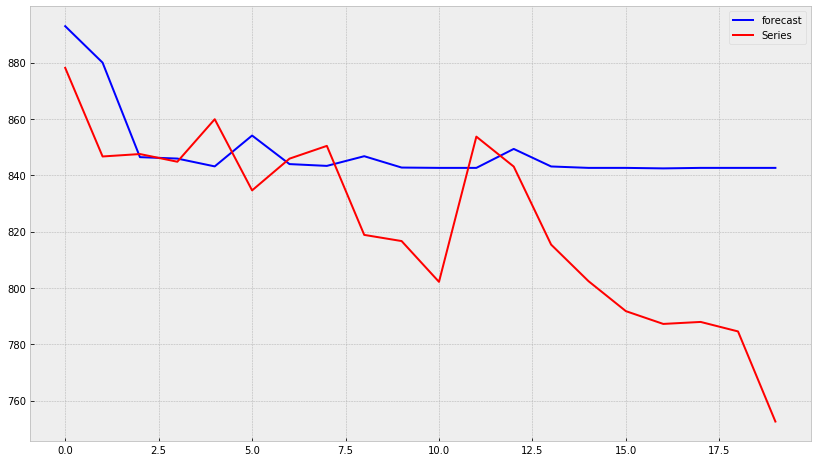

In [14]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    plt.plot(predictions,color='blue',label='forecast')
    plt.plot(series_tst, color='red', label='Series')
    plt.legend()
    plt.show()

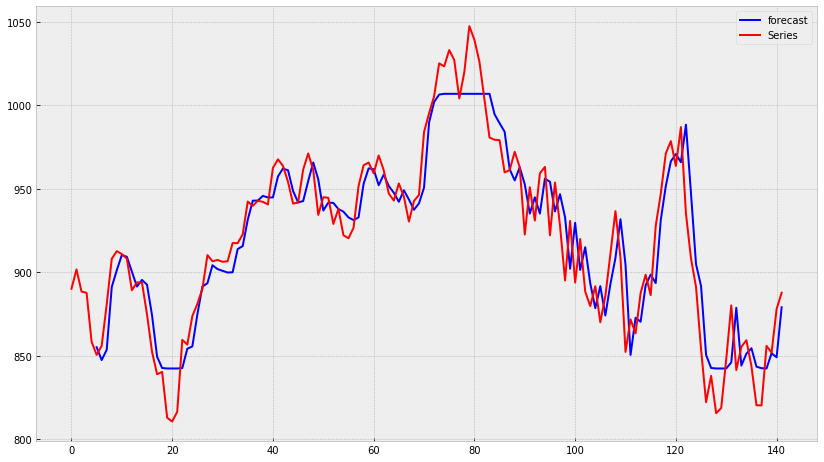

In [15]:
predictions = rfr.predict(X_trn)
predictions = [None]*lags + list(predictions )
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    plt.plot(predictions,color='blue',label='forecast')
    plt.plot(series, color='red', label='Series')
    plt.legend()
    plt.show()

Предсказание с использованием классического машинного обучения на модели RandomForestRegressor показало хорошие результаты в контексте параметра MSE и вида графика.